In [1]:
% run utils.ipynb

In [2]:
import json

In [3]:
def save(data, name):
    with open('../data/out.{}.json'.format(name), 'w') as f:
        json.dump(data, f, ensure_ascii=False)

In [4]:
lang_locations = pd.read_csv('../data/languages_coordinates.csv')
lang_locations.drop(['glottocode', 'macroarea'], 1, inplace=True)
lang_locations.head()

,name,isocode,level,latitude,longitude
0,Aalawa,NaN,dialect,NaN,NaN
1,Aantantara,NaN,dialect,NaN,NaN
2,Aari,aiw,language,5.95034,36.5721
3,Aariya,aay,language,NaN,NaN
4,Aasax,aas,language,-4.00679,36.8648


In [5]:
lang_locations.shape

(18975, 5)

In [6]:
relations = pd.read_csv('../data/etymwn.tsv', sep='\t', header=None)
relations.columns = ['src', 'rel', 'to']
relations = relations.assign(
    src_lang=relations.src.apply(lambda x: x.split(':')[0].strip()),
    src_word=relations.src.apply(lambda x: x.split(':')[1].strip().lower()),
    to_lang=relations.to.apply(lambda x: x.split(':')[0].strip()),
    to_word=relations.to.apply(lambda x: x.split(':')[1].strip().lower()),
)
relations = relations[
    ~relations.src_word.str.contains('-') & 
    ~relations.src_word.str.contains('\[') & 
    ~relations.to_word.str.contains('-') &
    ~relations.to_word.str.contains('\[') &
    ~relations.rel.isin(['rel:is_derived_from', 'rel:etymologically_related', 'derived'])
]
relations = relations[relations.to_word != relations.src_word]
relations.drop_duplicates(inplace=True)
relations.head()

,src,rel,to,src_lang,src_word,to_lang,to_word
0,aaq: Pawanobskewi,rel:etymological_origin_of,eng: Penobscot,aaq,pawanobskewi,eng,penobscot
1,aaq: senabe,rel:etymological_origin_of,eng: sannup,aaq,senabe,eng,sannup
2,abe: waniigan,rel:etymological_origin_of,eng: wangan,abe,waniigan,eng,wangan
3,abe: waniigan,rel:etymological_origin_of,eng: wannigan,abe,waniigan,eng,wannigan
5,adt: yuru,rel:etymological_origin_of,eng: euro,adt,yuru,eng,euro


In [7]:
relations.shape

(2819080, 7)

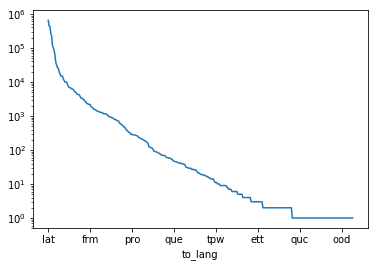

In [8]:
words_per_lang = relations.groupby(relations.to_lang).count().to_word
words_per_lang.sort_values(ascending=False).plot(logy=True);

In [9]:
min_word = 20
langs = pd.Series(words_per_lang[words_per_lang > min_word].index)
langs.sort_values()
langs.shape

(181,)

In [10]:
lang_locations[lang_locations.isocode.isin(langs)].shape

(153, 5)

In [11]:
macrolangs = pd.read_csv('../data/macrolanguages.tsv', sep='\t')
macrolangs.drop(['I_Status'], 1, inplace=True)
macrolangs = macrolangs[~macrolangs.I_Id.isin(langs) & macrolangs.I_Id.isin(lang_locations.isocode)]
macrolangs = dict(macrolangs.groupby(macrolangs.M_Id).first().reset_index().values)
len(macrolangs)

61

In [12]:
unknown_lang = ~langs.isin(lang_locations.isocode)
langs[unknown_lang] = langs[unknown_lang].apply(macrolangs.get)
langs = langs[langs.values != None]
langs.shape

(171,)

In [13]:
lang_locations_patch = np.array([
    [34.5, 41],
    [37.1, -3.5],
    [51, 0],
    [40.3, 45],
    [28, 84.5],
    [52, 5],
    [52, -1],
    [48, 2],
    [48.649, 11.4676],
    [48.649, 13.4676],
    [59.92, 10.71],
    [52, 5],
    [52, 0],
    [47, 2],
    [53.3, 6.3],
    [47.649, 12.4676],
    [53.2, -7.5],
    [55.7, 12],
    [32, 50],
    [44.3, 4],
    [56, 37],
    [51.152, 12.692],
    [40.4414, -1.11788],
    [39.8667, 32.8667],
    [52, -4],
    [32, 50],
    [52, 14]
])
lang_locations_patch.shape

(27, 2)

In [14]:
lang_locations.loc[lang_locations.isocode.isin(langs) & lang_locations.latitude.isnull(), ['latitude', 'longitude']] = lang_locations_patch

In [15]:
lang_locations[lang_locations.isocode.isin(langs) & lang_locations.latitude.isnull()]

,name,isocode,level,latitude,longitude


In [16]:
lang_locations = lang_locations[lang_locations.isocode.isin(langs)]
lang_locations.shape

(171, 5)

In [17]:
relations = relations[relations.src_lang.isin(langs) & relations.to_lang.isin(langs)]
relations.shape

(2766291, 7)

In [18]:
words = set()
words.update(relations.src_word)
words.update(relations.to_word)
len(words)

2523340

In [19]:
word_per_lang = pd.DataFrame(dict(
    word=np.r_[relations.src_word, relations.to_word],
    lang=np.r_[relations.src_lang, relations.to_lang],
))
word_per_lang.shape

(5532582, 2)

In [20]:
word_langs = dict(word_per_lang.groupby(word_per_lang.word).lang.apply(lambda x: list(np.unique(x))).reset_index().values)
len(word_langs)

2523340

In [21]:
save(word_langs, 'word_langs')

In [22]:
src_to_count = relations.groupby(relations.to_lang).to_word.count()
src_to_count.head()

to_lang
afr     473
aii      25
akk      66
ang    5001
arg      76
Name: to_word, dtype: int64

In [23]:
src_to = relations.groupby([relations.src_lang, relations.to_lang]).count().rel
src_to.shape

(2473,)

In [24]:
src_to.head()

src_lang  to_lang
afr       afr        322
          deu          3
          eng         15
          fra          1
          nld        129
Name: rel, dtype: int64

In [25]:
network_to = {}

for (src, to), count in src_to.items():
    if src not in network_to:
        network_to[src] = []
        
    ratio = count / src_to_count.loc[to]
    assert ratio <= 1
    network_to[src].append([to, ratio])

In [26]:
to_src_count = relations.groupby(relations.src_lang).src_word.count()
to_src_count.head()

src_lang
afr     473
aii      25
akk      66
ang    5001
arg      76
Name: src_word, dtype: int64

In [27]:
to_src = relations.groupby([relations.to_lang, relations.src_lang]).count().rel
to_src.shape

(2473,)

In [28]:
network_from = {}

for (to, src), count in to_src.items():
    if to not in network_from:
        network_from[to] = []
        
    ratio = count / to_src_count.loc[src]
    assert ratio <= 1
    network_from[to].append([src, ratio])

In [29]:
save({
    'to': network_to,
    'from': network_from,
    'locations': lang_locations.set_index('isocode').to_dict('index')
}, 'lang_network')    

In [30]:
mappings = pd.read_csv('../data/uwn.tsv', sep='\t', header=None)
mappings.columns = ['src', 'rel', 'to', 'weight']
mappings = mappings[mappings.rel != 'rel:means']
mappings = mappings.assign(
    lang=mappings.to.apply(lambda x: x.split('/')[1].strip()),
    word=mappings.to.apply(lambda x: x.split('/')[2].strip().lower()),
)
mappings = mappings[mappings.word.isin(words) & mappings.lang.isin(langs)]
mappings.drop(['weight', 'rel'], axis=1, inplace=True)
mappings.set_index('src', inplace=True)
mappings.head()

,to,lang,word
src,,,
s/n9002814,t/ind/Rusia,ind,rusia
s/n9002814,t/hun/Oroszország,hun,oroszország
s/n9002814,t/rus/Россия,rus,россия
s/n9002814,t/ina/Russia,ina,russia
s/n9002814,t/ces/Rusko,ces,rusko


In [31]:
mappings.shape

(586046, 3)

In [32]:
clusters = mappings.groupby(mappings.index).apply(lambda x: list(x.lang.str.cat(':' + x.word)))
clusters.head()

src
iso3166/AD    [ces:andorra, nno:andorra, vec:andora, ita:and...
iso3166/AE    [nld:verenigde arabische emiraten, fra:émirats...
iso3166/AF    [bos:afganistan, nob:afghanistan, ces:afgánist...
iso3166/AG    [rus:антигуа и барбуда, ukr:антигуа и барбуда,...
iso3166/AI    [dsb:anguilla, oci:anguilla, slk:anguilla, pol...
dtype: object

In [33]:
meanings = {}

for _, cluster in tqdm(clusters.items()):
        
    for lang_word in cluster:
        
        if lang_word not in meanings:
            meanings[lang_word] = set()
            
        meanings[lang_word].update(cluster)
        meanings[lang_word].remove(lang_word)
        
for key, values in meanings.items():
    meanings[key] = list(values)

65062it [00:02, 27007.73it/s]


In [34]:
len(meanings)

399608

In [35]:
save(meanings, 'word_meanings')

In [36]:
parents_rel = relations[relations.rel != 'rel:etymology']
parents = pd.DataFrame(dict(
     src=parents_rel.src_lang + ':' + parents_rel.src_word + ',',
    to=parents_rel.to_lang + ':' + parents_rel.to_word,
)).groupby('to').src.sum()
parents.head()

to
afr:aalmoesenier         afr:aalmoes,nld:aalmoezenier,
afr:aalmoeseniershuis                afr:aalmoesenier,
afr:aalwee                                   nld:aloë,
afr:aalwees                                afr:aalwee,
afr:aalwyne                                afr:aalwyn,
Name: src, dtype: object

In [37]:
parents_map = dict(parents.apply(lambda x: x.split(',')[:-1]).reset_index().values)
len(parents_map)

2350997

In [38]:
save(parents_map, 'word_parents')

In [39]:
children_rel = relations[relations.rel != 'rel:etymology']
children = pd.DataFrame(dict(
     src=children_rel.src_lang + ':' + children_rel.src_word,
    to=children_rel.to_lang + ':' + children_rel.to_word + ',',
)).groupby('src').to.sum()
children.head()

src
afr:aalmoes              afr:aalmoesenier,
afr:aalmoesenier    afr:aalmoeseniershuis,
afr:aalwee                    afr:aalwees,
afr:aalwyn                    afr:aalwyne,
afr:aambeeld                afr:aambeelde,
Name: to, dtype: object

In [40]:
children_map = dict(children.apply(lambda x: x.split(',')[:-1]).reset_index().values)
len(children_map)

476943

In [41]:
save(children_map, 'word_children')

In [42]:
def recurse(lang_word, mapping, seen=None):
    if seen is None:
        seen = set()

    if lang_word in seen:
        return []
    
    seen.add(lang_word)
    ps = mapping.get(lang_word, [])
    return [(p, recurse(p, mapping, seen.copy())) for p in ps]

In [43]:
recurse('eng:dog', parents_map)

[('eng:dogge', []),
 ('enm:dogge', [('ang:docga', [('ang:dogga', [])]), ('ang:dogga', [])])]

In [44]:
recurse('eng:dog', children_map)

[('eng:dogrib', []),
 ('eng:antidog', []),
 ('eng:bandog', [('eng:bandogs', [])]),
 ('eng:bonedog', [('eng:bonedogs', [])]),
 ('eng:coachdog', [('eng:coachdogs', [])]),
 ('eng:dogbolt', [('eng:dogbolts', [])]),
 ('eng:dogbone', [('eng:dogbones', [])]),
 ('eng:dogbreath', [('eng:dogbreaths', [])]),
 ('eng:dogcart', [('eng:dogcarts', [])]),
 ('eng:dogcatcher',
  [('eng:could not get elected dogcatcher', []), ('eng:dogcatchers', [])]),
 ('eng:dogdom', []),
 ('eng:dogface', [('eng:dogfaces', [])]),
 ('eng:doggess', [('eng:doggesses', [])]),
 ('eng:doggish',
  [('eng:doggishly', []),
   ('eng:doggishness', []),
   ('eng:doggishly', []),
   ('eng:doggishness', [])]),
 ('eng:doggy',
  [('eng:doggily', []),
   ('eng:dogginess', []),
   ('eng:doggier', []),
   ('eng:doggies', []),
   ('eng:doggiest', [])]),
 ('eng:doghole', [('eng:dogholes', [])]),
 ('eng:doghood', []),
 ('eng:doghouse', [('eng:doghouses', []), ('eng:in the doghouse', [])]),
 ('eng:dogkind', []),
 ('eng:dogless',
  [('eng:dogle

In [45]:
def recurse_unfold(lang_word, mapping):
    
    edges = []
    depth = 0
    
    def edgify(lang_word, history=[], seen=None):
        if seen is None:
            seen = set()
        
        ps = mapping.get(lang_word, [])

        if lang_word in seen:
            edges.append(history)
            return
        
        if not len(ps):
            edges.append(history + [lang_word])
            return

        seen.add(lang_word)
        [edgify(p, history + [lang_word], seen.copy()) for p in ps]

    edgify(lang_word)
    return edges

In [46]:
recurse_unfold('eng:dog', parents_map)

[['eng:dog', 'eng:dogge'],
 ['eng:dog', 'enm:dogge', 'ang:docga', 'ang:dogga'],
 ['eng:dog', 'enm:dogge', 'ang:dogga']]

In [47]:
recurse_unfold('eng:dog', children_map)

[['eng:dog', 'eng:dogrib'],
 ['eng:dog', 'eng:antidog'],
 ['eng:dog', 'eng:bandog', 'eng:bandogs'],
 ['eng:dog', 'eng:bonedog', 'eng:bonedogs'],
 ['eng:dog', 'eng:coachdog', 'eng:coachdogs'],
 ['eng:dog', 'eng:dogbolt', 'eng:dogbolts'],
 ['eng:dog', 'eng:dogbone', 'eng:dogbones'],
 ['eng:dog', 'eng:dogbreath', 'eng:dogbreaths'],
 ['eng:dog', 'eng:dogcart', 'eng:dogcarts'],
 ['eng:dog', 'eng:dogcatcher', 'eng:could not get elected dogcatcher'],
 ['eng:dog', 'eng:dogcatcher', 'eng:dogcatchers'],
 ['eng:dog', 'eng:dogdom'],
 ['eng:dog', 'eng:dogface', 'eng:dogfaces'],
 ['eng:dog', 'eng:doggess', 'eng:doggesses'],
 ['eng:dog', 'eng:doggish', 'eng:doggishly'],
 ['eng:dog', 'eng:doggish', 'eng:doggishness'],
 ['eng:dog', 'eng:doggish', 'eng:doggishly'],
 ['eng:dog', 'eng:doggish', 'eng:doggishness'],
 ['eng:dog', 'eng:doggy', 'eng:doggily'],
 ['eng:dog', 'eng:doggy', 'eng:dogginess'],
 ['eng:dog', 'eng:doggy', 'eng:doggier'],
 ['eng:dog', 'eng:doggy', 'eng:doggies'],
 ['eng:dog', 'eng:doggy'

In [48]:
lang_words = (parents_rel.src_lang + ':' + parents_rel.src_word).values
lang_words.shape

(2486467,)

In [49]:
lang_influences = {}

for lang_word in tqdm(lang_words):
    edges = recurse_unfold(lang_word, parents_map) + recurse_unfold(lang_word, children_map)
    
    for edge in edges:
        lang = edge[0].split(':')[0]

        if lang not in lang_influences:
            lang_influences[lang] = []

        lang_influences[lang].append(edge)

100%|██████████| 2486467/2486467 [11:03<00:00, 3747.22it/s]


In [50]:
lang_influences_ord = { k: sorted(v, key=len, reverse=True) for k, v in tqdm(lang_influences.items()) }

100%|██████████| 149/149 [01:31<00:00,  1.63it/s]


In [51]:
n_samples = 50

In [52]:
lang_samples = {}

for lang in tqdm(langs):
    if lang in lang_influences:
        top_starters = [lang_word[0].split(':')[1] for lang_word in lang_influences_ord[lang]]

        lang_samples[lang] = [top_starters[i] for i in sorted(np.unique(top_starters, return_index=True)[1])][:n_samples]

100%|██████████| 171/171 [09:52<00:00,  3.46s/it]


In [53]:
save(lang_samples, 'lang_samples')

In [54]:
relation_groups = relations.groupby(relations.src_lang).apply(lambda x: x.groupby(x.to_lang).src_word.apply(list))
relation_groups.shape

(2473,)

In [55]:
relation_samples = {}

for _, (src, to, words) in tqdm(relation_groups.reset_index().iterrows()):
    relation = '{}{}'.format(src, to)
    relation_samples[relation] = np.random.choice(words, min(n_samples, len(words))).tolist()

2473it [00:51, 48.14it/s]


In [56]:
save(relation_samples, 'relation_samples')